In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(tf.__version__, tf.config.list_physical_devices('GPU'))  # 查看能否使用gpu

In [3]:
class_names = ['BigCake', 'Broken', 'ColorCell', 'DarkGolden', 'GoldenCell', 'OverPolish', 'WhiteCell']
class_label = {class_name : i for i, class_name in enumerate(class_names)}
class_label

{'BigCake': 0,
 'Broken': 1,
 'ColorCell': 2,
 'DarkGolden': 3,
 'GoldenCell': 4,
 'OverPolish': 5,
 'WhiteCell': 6}

In [4]:
def load_images(directory, num_files = 5):
    images = []
    file_list = os.listdir(directory)[:num_files]
    for filename in tqdm(file_list, desc = f"Loading images from{directory}"):
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path)
        img = img.resize((150, 150))
        images.append(img)
    return images

In [5]:
img_path = "E:\样本库测试\大缺陷样本库\背膜\抠图256"
BigCake_train = img_path + '\BigCake'
Broken_train = img_path + '\Broken'
ColorCell_train = img_path + '\ColorCell'
DarkGolden_train = img_path + '\DarkGolden'
GoldenCell_train = img_path + '\GoldenCell'
OverPolish_train = img_path + '\OverPolish'
WhiteCell_train = img_path + '\WhiteCell'
BigCake_train

'E:\\样本库测试\\大缺陷样本库\\背膜\\抠图256\\BigCake'

In [6]:
BigCake_img = load_images(BigCake_train)
Broken_img = load_images(Broken_train)
ColorCell_img = load_images(ColorCell_train)
DarkGolden_img = load_images(DarkGolden_train)
GoldenCell_img = load_images(GoldenCell_train)
OverPolish_img = load_images(OverPolish_train)
WhiteCell_img = load_images(WhiteCell_train)

Loading images fromE:\样本库测试\大缺陷样本库\背膜\抠图256\BigCake: 100%|███████████████| 5/5 [00:00<00:00, 367.04it/s]
Loading images fromE:\样本库测试\大缺陷样本库\背膜\抠图256\Broken: 100%|████████████████| 5/5 [00:00<00:00, 593.05it/s]
Loading images fromE:\样本库测试\大缺陷样本库\背膜\抠图256\ColorCell: 100%|█████████████| 5/5 [00:00<00:00, 557.26it/s]
Loading images fromE:\样本库测试\大缺陷样本库\背膜\抠图256\DarkGolden: 100%|████████████| 5/5 [00:00<00:00, 710.59it/s]
Loading images fromE:\样本库测试\大缺陷样本库\背膜\抠图256\GoldenCell: 100%|████████████| 5/5 [00:00<00:00, 624.86it/s]
Loading images fromE:\样本库测试\大缺陷样本库\背膜\抠图256\OverPolish: 100%|████████████| 5/5 [00:00<00:00, 557.52it/s]
Loading images fromE:\样本库测试\大缺陷样本库\背膜\抠图256\WhiteCell: 100%|█████████████| 5/5 [00:00<00:00, 535.42it/s]


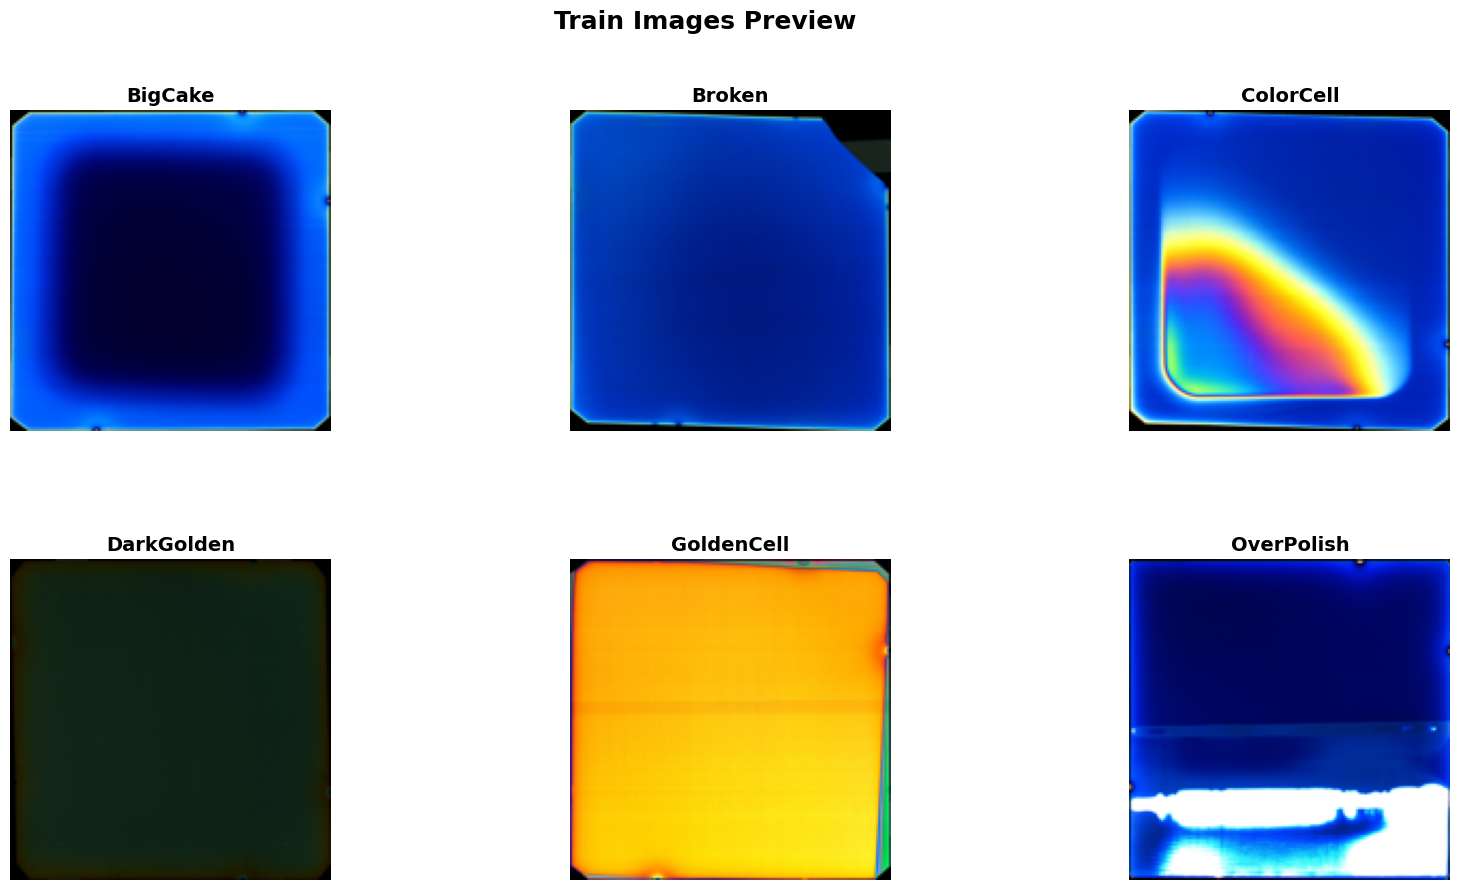

In [7]:
#展示图像
plt.rcParams["figure.figsize"] = [20, 10]
fig, axs = plt.subplots(2, 3, gridspec_kw={'hspace':0.4, 'wspace':0.3})

categories = ['BigCake', 'Broken', 'ColorCell', 'DarkGolden', 'GoldenCell', 'OverPolish', 'WhiteCell']
images = [BigCake_img, Broken_img, ColorCell_img, DarkGolden_img, GoldenCell_img, OverPolish_img, WhiteCell_img]

for i, (category, category_imgs) in enumerate(zip(categories[:6], images[:6])):
    axs[i // 3, i%3].imshow(category_imgs[0])
    axs[i // 3, i%3].axis('off')
    axs[i // 3, i%3].set_title(category, fontsize = 14, fontweight = 'bold')

plt.suptitle("Train Images Preview", fontsize = 18, fontweight = 'bold')
plt.tight_layout(rect = [0, 0, 1, 0.95])
plt.show()
    
    

In [8]:
#加载数据
def load_data():
    datasets = [r'E:\样本库测试\大缺陷样本库\背膜\output\train',
               r'E:\样本库测试\大缺陷样本库\背膜\output\test']

    output = []

    for dataset in  datasets:
        images, labels = [], []
        print(f"Loading {dataset}...")

        for folder in os.listdir(dataset):
            label = class_label[folder]
            folder_path = os.path.join(dataset, folder)

            for file in tqdm(os.listdir(folder_path), desc = f"Processing{folder}"):
                img_path = os.path.join(folder_path, file)
                image = Image.open(img_path)#.resize((150, 150))
                images.append(image)
                labels.append(label)
        images = np.stack(images)
        labels = np.array(labels, dtype = 'int32')
        output.append((images, labels))
    return output

In [9]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading E:\样本库测试\大缺陷样本库\背膜\output\train...


ProcessingWhiteCell: 100%|███████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 6354.12it/s]


Loading E:\样本库测试\大缺陷样本库\背膜\output\test...


ProcessingWhiteCell: 100%|███████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 2610.88it/s]


In [10]:
train_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
def create_gen():
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function = None,
    validation_split = 0.1
    )
    
    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function = None
    )

In [11]:
#归一化
train_images = train_images / 255.0
test_images = test_images / 255.0

In [12]:
train_images_tensor = tf.convert_to_tensor(train_images, dtype = tf.float32)
train_labels_tensor = tf.convert_to_tensor(train_labels, dtype = tf.float32)

test_images_tensor = tf.convert_to_tensor(test_images, dtype = tf.float32)
test_labels_tensor = tf.convert_to_tensor(test_labels, dtype = tf.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images_tensor, train_labels_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images_tensor, test_labels_tensor))

buffer_size = 10000

train_dataset = train_dataset.shuffle(buffer_size = buffer_size, seed = 25)
test_dataset = test_dataset.shuffle(buffer_size = buffer_size, seed = 25)

In [22]:
print(train_dataset)
n_train = train_labels_tensor.shape[0]
n_test = test_labels_tensor.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of testing examples: {}".format(n_test))

<ShuffleDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>
Number of training examples: 815
Number of testing examples: 207


In [16]:
#加载模型
model = Sequential([
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),
    Dense(128, activation = 'relu'),
    Dropout(0.4),
    Dense(7, activation = 'softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 254, 254, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_4 (Batc  (None, 125, 125, 64)     256       
 hNormalization)                                                 
                                                      

In [24]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = Adam(),
              metrics = ['accuracy'])

history = model.fit(train_images_tensor,
                   train_labels_tensor,
                   batch_size = 32,
                   epochs = 25,
                   #validation_split = 0.3)
                   )

Epoch 1/25
26/26 [==============================] - 115s 4s/step - loss: 0.8661 - accuracy: 0.8012
Epoch 2/25
 2/26 [=>............................] - ETA: 1:42 - loss: 0.3574 - accuracy: 0.9219

KeyboardInterrupt: 

In [ ]:
def plot_accuracy_loss(history):
    fig, axes = plt.subplots(1, 2, figsize = (14, 6))
    axes[0].plot(history.history['accuracy'], 'b--o', label = "Training Accuracy")
    axes[0].plot(history.history['val_accuracy'], 'r--o', label = "Validation Accuracy")
    axes[0].set_title("Training vs Validation Accuracy", fontsize = 14)
    axes[0].set_xlabel("Epoch", fontsize = 12)
    axes[0].set_ylabel("Accuracy", fontsize = 12)
    axes[0].legend(loc = "lower right")
    axes[0].grid(True)

    axes[1].plot(history.history['loss'], 'b--o', label = "Training Loss")
    axes[1].plot(history.history['val_loss'], 'r--o', label = "Validation Loss")
    axes[1].set_title("Training vs Validation Loss", fontsize = 14)
    axes[1].set_xlabel("Epoch", fontsize = 12)
    axes[1].set_ylabel("Loss", fontsize = 12)
    axes[1].legend(loc = 'upper right')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_accuracy_loss(history)

In [ ]:
test_loss = model.evaluate(test_images, test_labels)


In [ ]:
def display_random_image(class_names, images, labels):
    index = np.random.randint(image.shape[0])
    plt.figure(figsize = (3, 3))
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

In [ ]:
def display_multiple_predictions(class_names, images, labels, predictions, num_images = 10):
    plt.figure(figsize = (15, 15))
    labels = tf.cast(labels, tf.int32)
    for i in range(num_images):
        plt.subplot(5, 2, i+1)
        plt.imshow(images[i])
        actual_label = class_names[labels[i]]
        predicted_label = class_names[predictions[i]]
        color = 'green' if predicted_label == actual_label else 'red'
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", color = color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

predictions = model.predict(test_images_tensor)
pred_labels = np.argmax(predictions, axis = 1)
display_multiple_predictions(class_names, test_images_tensor, test_labels_tensor, pred_labels, num_images = 10)

In [ ]:
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)

    plt.figure(figsize = (8, 6))
    sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_names, yticklabels = class_names)
    plt.title("Confusion Matrix", fontsize = 16)
    plt.xlabel("Predicted Labels", fontsize = 12)
    plt.ylabel("True Labels", fontsize = 12)
    plt.tight_layout()
    plt.show()

predictions = model.predict(test_images_tensor)
pred_labels = np.argmax(predictions, axis = 1)

plot_confusion_matrix(test_labels_tensor, pred_labels, class_names)

In [ ]:
#加载ResNet50

from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam

base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False;

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(7, activation = 'softmax')
])

model.summary()

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(),
             metrics = ['accuracy'])

history = model.fit(train_images_tensor,
                   train_labels_tensor,
                   batch_size = 32,
                   epochs = 50,
                   validation_split = 0.3)

In [ ]:
plot_accuracy_loss(history)


In [ ]:
predictions = model.predict(test_images_tensor) 
pred_labels = np.argmax(predictions, axis=1)  
plot_confusion_matrix(test_labels_tensor, pred_labels, class_names)
